## Data preparation and processing

In [1]:
import numpy as np

In [2]:
#the asteorid starts its journey at some point (x,y) with velocity (vx,vy)
#its movement is affected by a gracity coming from a sun of mass 1 and radius 1
#the gravity constant is assumed to be 1
#we want to predict whether the asteroid will hit the sun, reach a stable orbit or escape to infinity

#equations of motion
#q' = p
#p' = -1/|q|**3 *q

In [3]:
from numpy.linalg import norm
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def F(x,t):
    #vector field
    q1,q2,p1,p2 = x
    dq1,dq2 = p1,p2
    q = np.array([q1,q2])
    a = -1/norm(q)**3
    dp1,dp2 = a*q1,a*q2
    dx = np.array([dq1,dq2,dp1,dp2])
    return dx

def energy(q,p):
    #energy
    R = norm(q)
    v = norm(p)
    E = .5*v**2 - 1/R
    return E

#functions predicting the outcome return
#0 if the astroid hits the sun
#1 if it reaches a stable orbit
#2 if it escapes to infinity
    
def num_end(q,p):
    #predict with numerical simulations
    q1,q2 = q
    p1,p2 = p
    x0 = np.array([q1,q2,p1,p2])
    T = np.linspace(0,1000,10000)
    
    sol = odeint(F,x0,T)
    
    for x in sol:
        qq = np.array([x[0],x[1]])
        if norm(qq)<=1:
            return 0
        
    E = energy(q,p)
    if E<0:
        return 1
    else:
        return 2
    
def sym_end(q,p):
    #predict with strict calculations
    #we will use two equations
    #a = R/(2*R-R*v**2)
    #e**2 = 1-c**2/a where c is the angular momentum
    
    E = energy(q,p)
    a = -2/E
    
    #now we need to calculate the momentum
    R = norm(q)
    dR = np.dot(q,p)/R
    cost = q[0]/R
    sint = q[1]/R
    if sint!=0:
        dt = (dR*cost-p[0])/(R*sint)
    else:
        dt = (p[1]-dR*sint)/(R*cost)
    c = R**2*dt
    
    e = np.sqrt(1-c**2/a)
    
    #the minimal distance to the sun is a(1-e)
    if a*(1-e)<1 and E<0:
        return 0
    elif a*(1-e)<1 and E>0:
        if dR>0:
            return 2
        else:
            return 0
    elif a*(1-e)>1 and E<0:
        return 1
    else:
        return 2
    
def draw_orbit(q,p):
    q1,q2 = q
    p1,p2 = p
    x0 = np.array([q1,q2,p1,p2])
    T = np.linspace(0,1000,10000)
    
    sol = odeint(F,x0,T)
    Xs = sol[:,0]
    Ys = sol[:,1]
    plt.grid()
    plt.scatter(Xs,Ys,s=2)
    plt.scatter([0],[0],s=200)

In [35]:
#generating training data
from numpy.random import rand

train_samples = []
num_labels = []
sym_labels = []
for j in range(10000):
    #generate a random point outside of a sun of radius not bigger than 10
    q = 20*rand(2)-np.array([10,10])
    while norm(q)<=1 and norm(q)>=10:
        q = 20*rand(2)-np.array([10,10])
    
    #generate random velocity p with |p|<1
    p = 2*rand(2)-np.array([1,1])
    while norm(p)>=1:
        p = 2*rand(2)-np.array([1,1])
    
    x = np.concatenate((q,p))
    train_samples.append(x)
    #num_labels.append(num_end(q,p))
    sym_labels.append(sym_end(q,p))
    print('sample',j+1,end='\r')
       
train_samples = np.array(train_samples)
num_labels = np.array(num_labels)
sym_labels = np.array(sym_labels)
print()
print('done')

sample 100002081 2795 5074 5855 7302 9436
done


In [36]:
from numpy import count_nonzero
print(count_nonzero(sym_labels==0))
print(count_nonzero(sym_labels==1))
print(count_nonzero(sym_labels==2))

2390
1437
6173


## Neural Network Model

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_samples = scaler.fit_transform(train_samples)

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.utils import shuffle

In [106]:
model = Sequential([
    Dense(units=32, input_shape=(4,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=3, activation='softmax')
])

In [107]:
model.compile(optimizer=Adam(learning_rate=.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [108]:
model.fit(x=scaled_train_samples, y=sym_labels, validation_split=.1, batch_size=10, epochs=50, shuffle=True, verbose=1)


Epoch 1/50
900/900 [==============================] - 2s 2ms/step - loss: 0.8495 - accuracy: 0.6283 - val_loss: 0.7684 - val_accuracy: 0.6810
Epoch 2/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6971 - accuracy: 0.7149 - val_loss: 0.6267 - val_accuracy: 0.7460
Epoch 3/50
900/900 [==============================] - 1s 2ms/step - loss: 0.5675 - accuracy: 0.7579 - val_loss: 0.5529 - val_accuracy: 0.7540
Epoch 4/50
900/900 [==============================] - 2s 2ms/step - loss: 0.5250 - accuracy: 0.7657 - val_loss: 0.5296 - val_accuracy: 0.7610
Epoch 5/50
900/900 [==============================] - 2s 2ms/step - loss: 0.4986 - accuracy: 0.7722 - val_loss: 0.5095 - val_accuracy: 0.7830
Epoch 6/50
900/900 [==============================] - 1s 2ms/step - loss: 0.4732 - accuracy: 0.7840 - val_loss: 0.4766 - val_accuracy: 0.7980
Epoch 7/50
900/900 [==============================] - 2s 2ms/step - loss: 0.4571 - accuracy: 0.7959 - val_loss: 0.4881 - val_accuracy: 0.7800
Epoch 

In [109]:
#creating the test set
test_labels = []
test_samples= []
for j in range(500):
    #generate a random point outside of a sun of radius not bigger than 10
    q = 20*np.random.rand(2)-np.array([10,10])
    while np.linalg.norm(q)<=1 and np.linalg.norm(q)>=10:
        q = 20*np.random.rand(2)-np.array([10,10])
    
    #generate random velocity p with |p|<1
    p = 2*np.random.rand(2)-np.array([1,1])
    while np.linalg.norm(p)>=1:
        p = 2*np.random.rand(2)-np.array([1,1])
        
    x = np.concatenate((q,p))
    test_samples.append(x)
    
    test_labels.append(sym_end(q,p))
        
test_samples = np.array(test_samples)
test_labels = np.array(test_labels)

scaled_test_samples = scaler.fit_transform(test_samples)

In [110]:
predictions = model.predict(x=scaled_test_samples, batch_size=10, verbose=2)

50/50 - 0s - 185ms/epoch - 4ms/step


In [111]:
rounded_predictions = np.argmax(predictions, axis=-1)

## Confusion matrix

In [112]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [113]:
cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)

In [114]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,classes)
    
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print("Confusion matrix, w/o normalization")
        
#    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                 horizontalalignment="center",
                 color="white" if cm[i,j]>thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

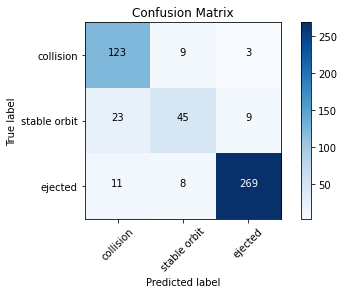

In [115]:
cm_plot_labels = ["collision", "stable orbit", "ejected"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

## Saving and loading a model

In [33]:
#model.save()
import os.path
if os.path.isfile('orbit_predicter.h5') is False:
    model.save('orbit_predicter.h5')

In [1]:
from tensorflow.keras.models import load_model
new_model = load_model('orbit_predicter.h5')

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                80        
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 723
Trainable params: 723
Non-trainable params: 0
_________________________________________________________________


In [35]:
new_model.get_weights()

[array([[-0.22655116,  0.33867258, -0.50208896, -0.40977374, -0.57539916,
          0.5506049 ,  0.5145097 , -0.4831272 , -0.41865402, -0.81163454,
         -0.34574664,  0.41408816,  0.5450403 ,  0.41499475,  0.44062307,
         -0.00989276],
        [ 0.60226464, -0.2687456 ,  0.98902774,  0.50646573,  0.42968524,
          0.6967502 ,  0.15656962,  0.5261817 , -0.6432229 ,  0.4558973 ,
         -0.28066137,  0.31260735,  0.11798303, -0.04086452, -0.5575452 ,
         -0.01623344],
        [-0.54082257, -0.42660686,  0.03508973, -0.5030893 , -0.18338025,
         -0.8329621 ,  0.86781365,  0.90437275, -0.18513025,  0.52172446,
         -0.13757595,  0.5156059 ,  0.60362947, -0.98914284, -0.44345534,
         -0.05203015],
        [ 0.30536282, -0.22315533, -0.49611452, -0.39044163,  0.90586764,
         -0.05900914,  0.3844152 , -0.45437205, -0.15907627,  0.49598724,
         -0.07867656,  0.41097507,  0.52826476,  0.9087413 ,  1.1406305 ,
         -0.5125958 ]], dtype=float32),
 ar